# Homework 6

# Задача №1 - Выделить береговую линию

Теперь приступим к задаче сегментации на картинках. Реализуйте программу, которая определить береговую линию, то есть разделит изображение на 2 класса: берег и вода. 

Примеры изображений:
<table><tr>
    <td> <img src="ships/0d5b831d8.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="ships/8bb60a003.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="ships/161dfbbdc.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

**Используемые библиотеки:**

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import skimage
import os

**Константы:**

In [13]:
path_folder = './ships/'

___

**Функции для вычислений:**

In [14]:
def get_modes(channel: np.ndarray, segmented: np.ndarray, 
              range_channel: tuple) -> (np.ndarray, np.ndarray):
    """
    Функция для получения самого популярного значения по заданному
    каналу для каждого кластера сегментированного изображения
    -----------------------------------------------------------------
    
    :param channel: двумерный массив - один из каналов изображения
    :param segmented: двумерный массив - сегментированное изображение
    :param range_channel: два числа - максимальное и минимальное 
                          значение в канале
    -----------------------------------------------------------------
    
    :return: массив мод и массив индексов пикселей, где в i-ой ячейке
             лежат индексы пикселей изображения, относящихся к i-ому 
             кластеру
    -----------------------------------------------------------------
    """
    
    labels = np.unique(segmented)
    
    indices = [np.where(segmented == label) for label in labels]
    indices = np.array(indices, dtype=object)

    modes = np.array([])

    for index in indices:

        segment = channel[index[0], index[1]]
        
        bins = range_channel[-1] - range_channel[0] + 1
        hist, _ = np.histogram(segment, bins=bins, range=range_channel)

        modes = np.append(modes, np.argmax(hist))
        
    return modes, indices

In [15]:
def perform_postprocessing(image: np.ndarray, segmented: np.ndarray) -> np.ndarray:
    """
    Функция для пост-обработки сегментированного изображения
    
    Пост-обработка заключается в сокращении числа кластеров до двух
    по пороговому правилу для моды канала H сегмента
    -----------------------------------------------------------------
    
    :param image: трёхмерный массив - трехканальное изображение в HSV
    :param segmented: двумерный массив - сегментированное изображение
    -----------------------------------------------------------------
    
    :return: двумерный массив - обработанное сегментированное 
             изображение
    -----------------------------------------------------------------
    """
    
    thresh_min, thresh_max = 75, 130
    
    channel_h = skimage.color.rgb2hsv(image)[..., 0]
    channel_h = (channel_h * 180).astype(int)

    modes, indices = get_modes(channel_h, segmented, range_channel=(0, 179))
        
    indices_water = indices[(thresh_min <= modes) & (modes <= thresh_max)]
    indices_ground = indices[(modes < thresh_min) | (thresh_max < modes)]
    
    for index in indices_water:
        segmented[index[0], index[1]] = 0
        
    for index in indices_ground:
        segmented[index[0], index[1]] = 1
        
    if not indices_water.size:
        
        i = np.argmin(np.abs(modes - thresh_min))
        segmented[indices[i][0], indices[i][1]] = 0
        
    return segmented

In [16]:
def perform_segmentation(image: np.ndarray, threshold: int = 10) -> np.ndarray:
    """
    Функция для сегментации
    -----------------------------------------------------------------
    
    :param image: трёхмерный массив - трехканальное изображение в HSV
    :param threshold: целое число - максимальное расстояние между 
                      кластерами                 
    -----------------------------------------------------------------
    
    :return: двумерный массив - обработанное сегментированное 
             изображение
    -----------------------------------------------------------------
    """
    
    segmented = skimage.segmentation.felzenszwalb(image, scale=150, 
                                                  sigma=3, min_size=70)
    
    channel_h = skimage.color.rgb2hsv(image)[..., 0]
    channel_h = (channel_h * 180).astype(int)
    
    while True:

        labels = np.unique(segmented)
        
        if labels.size < 2:
            break

        modes, indices = get_modes(channel_h, segmented, range_channel=(0, 179))

        dists = np.abs(modes[:, np.newaxis] - modes)
        dists += np.eye(dists.shape[0]) * 180
        
        if dists.min() > threshold:
            break
            
        i, j = np.unravel_index(np.argmin(dists), dists.shape)
        segmented[indices[i][0], indices[i][1]] = labels[j]
        
    return perform_postprocessing(image, segmented)

**Функции для визуализации:**

In [17]:
def plot_image(ax, image, title, contours=None):
    
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.imshow(image)
    
    if contours is not None:
        ax.imshow(contours, alpha=0.2)
        ax.contour(contours, colors='red')
        
    ax.axis('off')

In [18]:
def compute_visualize_results(images, start=0, stop=None):
    """
    Функция для визуализации работы алгоритмов
    -----------------------------------------------------------------
    
    :param images: список трехканальных изображений
    :param start: целое число - начало среза в списке images
    :param stop: целое число - конец среза в списке images
    -----------------------------------------------------------------
    """
    
    stop = len(images) if stop is None else stop
    
    images_slice = images[start: stop]
    
    fig, axes = plt.subplots(len(images_slice), 4, 
                             figsize=(24, 5 * len(images_slice)))
    axes = axes.ravel()

    for i, image in tqdm(enumerate(images_slice)):

        segmented = skimage.segmentation.felzenszwalb(image, scale=300, 
                                                      sigma=3, min_size=50)

        plot_image(axes[i * 4 + 1], image, 'Pure Felzenszwalb', segmented)

        segmented1 = perform_postprocessing(image, segmented)
        segmented2 = perform_segmentation(image)

        plot_image(axes[i * 4], image, 'Original')
        plot_image(axes[i * 4 + 2], image, 'Algo1', segmented1)
        plot_image(axes[i * 4 + 3], image, 'Algo2', segmented2)

    plt.show()

___

**Считывание данных:**

Папка с картинками лежит в одной директории с ноутбуком.

In [19]:
images = []

for image_name in os.listdir(path_folder):
    
    image = skimage.io.imread(f'{path_folder}{image_name}')    
    new_shape = tuple(map(lambda x: int(x / 2), image.shape[:-1]))
    image = skimage.transform.resize(image, new_shape)
    
    images.append(image)

**Результаты работы алгоритмов:**

В связи с увеличением размера файла при тестировании алгортмов на всех 34 картинках, показана сегментация только на 5 картинках для возможности загрузки файла в гугл форму. Для просмотра результатов работы алгоритма на всех тестовых данных, необходимо запустить функцию `compute_visualize_results()` с настройками по умолчанию.

5it [00:09,  1.81s/it]


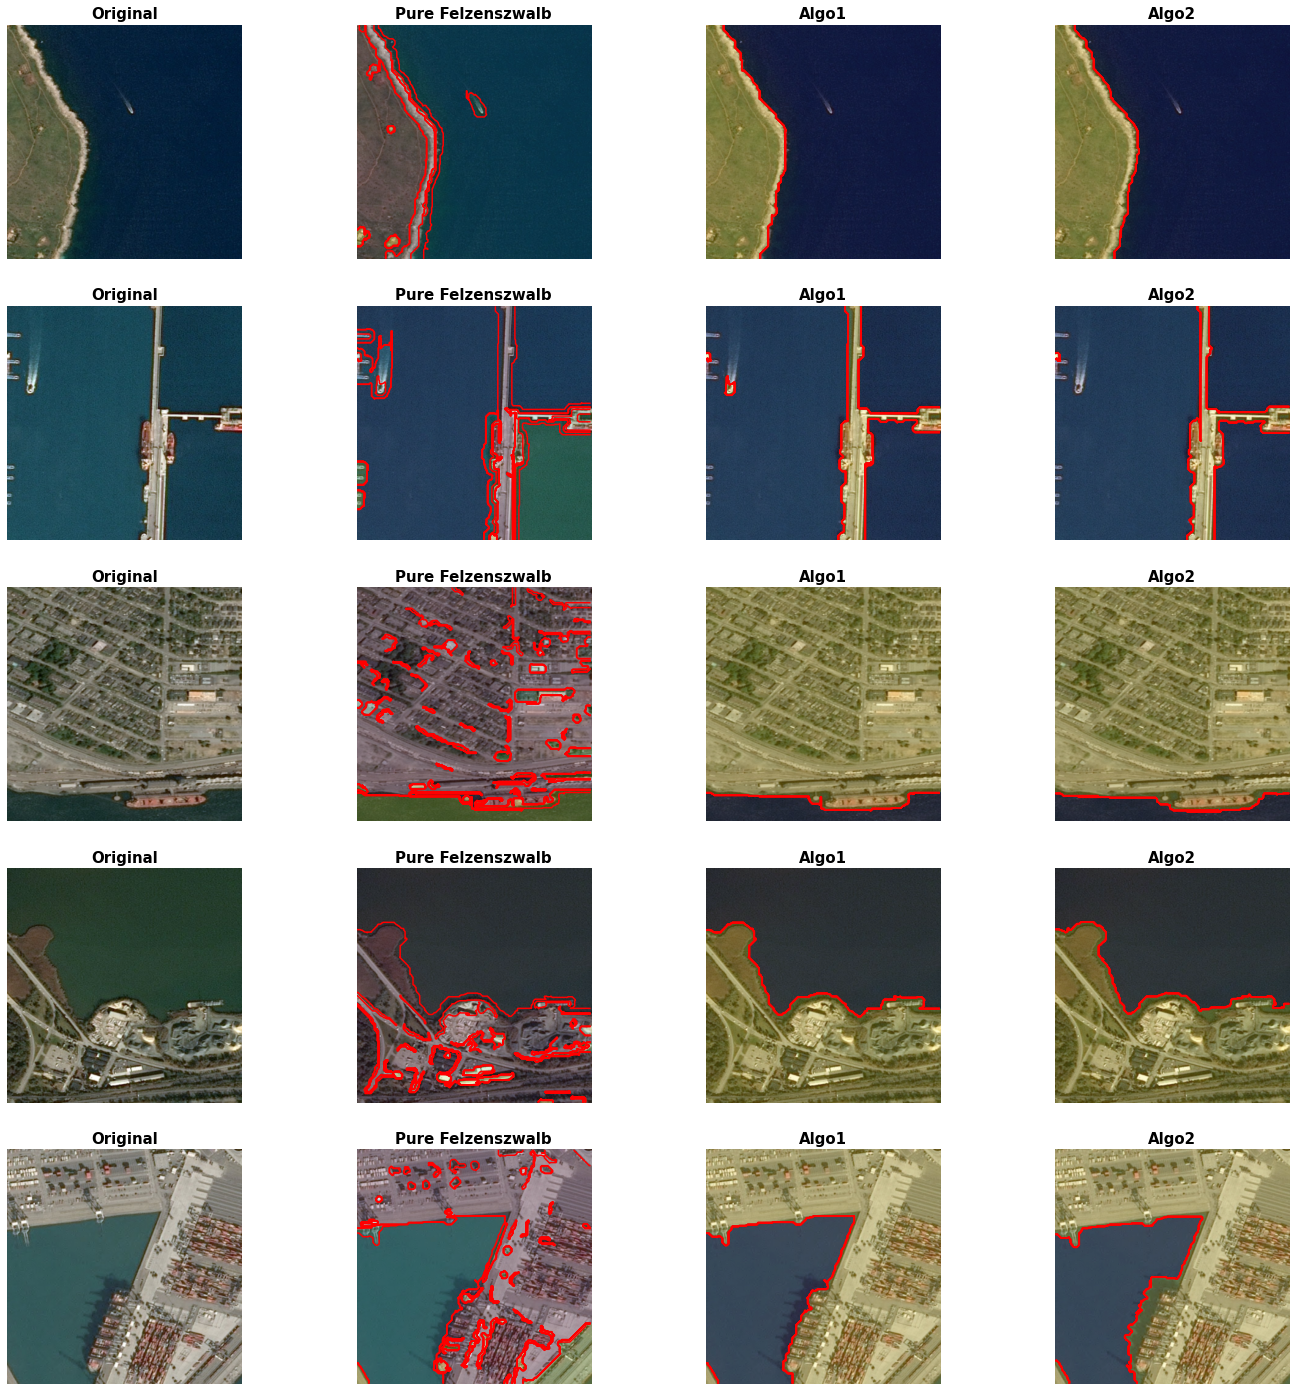

In [20]:
compute_visualize_results(images, start=4, stop=9)